In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import lru_cache
from typing import Union, List, Tuple
import os
import sys
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
from t_core.bsplinefield import BSplineField
from t_core.fields import GaussianDisplacementField

## Recover known weights

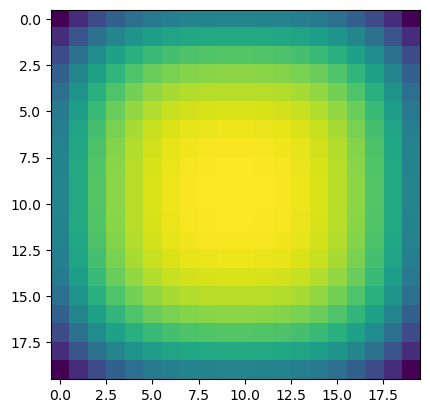

In [2]:
weights = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,0,0,0,0]]).reshape(1,5,5)
weights = np.stack([np.zeros_like(weights), weights, weights, weights, np.zeros_like(weights)]).reshape(1,5,5,5)
weights = torch.tensor(weights, dtype=torch.float32)
tbf = BSplineField(weights, False)
x = torch.linspace(-1+1e-4, 1-1e-4, 20)
y = torch.linspace(-1+1e-4, 1-1e-4, 20)
z = torch.linspace(-1+1e-4, 1-1e-4, 20)
X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
u = tbf.displacement(X, Y, Z, 0)
plt.imshow(u[:,:,len(z)//2].numpy())
plt.show()
_x = X.flatten()
_y = Y.flatten()
_z = Z.flatten()
assert torch.allclose(
    tbf.compute_weights_from_displacement(_x, _y, _z, u.flatten()),
    weights, atol=1e-3, rtol=1e-3
    )

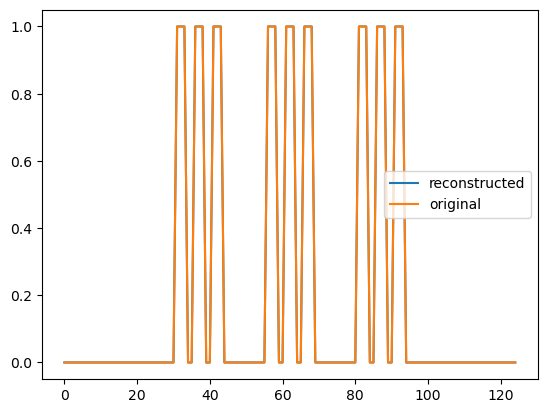

In [3]:
plt.plot(tbf.compute_weights_from_displacement(_x, _y, _z, u.flatten()).flatten().numpy(), label='reconstructed')
plt.plot(weights.flatten().numpy(), label='original')
plt.legend()
plt.show()

## Fit real field

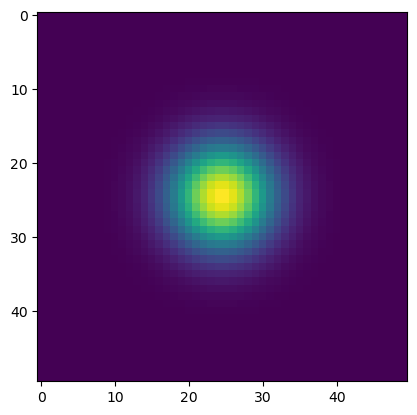

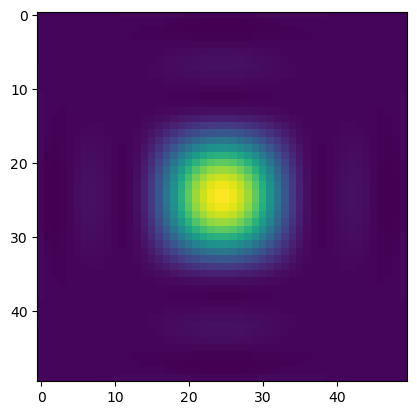

In [4]:
df = GaussianDisplacementField([0.2,0.2,0.2], [0.05,0,0], [0,0,0])

x = torch.linspace(-1+1e-4, 1-1e-4, 50)
y = torch.linspace(-1+1e-4, 1-1e-4, 50)
z = torch.linspace(-1+1e-4, 1-1e-4, 50)
X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
u = df.displacement(X, Y, Z, 0)
plt.imshow(u[:,:,len(z)//2].numpy())
plt.show()

weights = torch.zeros(1,10,10,10)
bf = BSplineField(weights, False)
_x = X.flatten()
_y = Y.flatten()
_z = Z.flatten()
computed_weights = bf.compute_weights_from_displacement(_x, _y, _z, u.flatten())
bf.phi_x[0,...] = computed_weights
# plot the predicted displacement
u_post = bf.displacement(X, Y, Z, 0)
plt.imshow(u_post[:,:,len(z)//2].numpy())
plt.show()

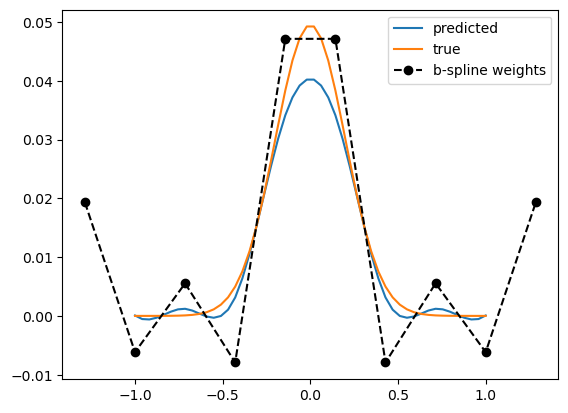

In [5]:
plt.plot(x.numpy(), u_post[:, len(y)//2, len(z)//2].numpy(), label='predicted')
plt.plot(x.numpy(), u[:, len(y)//2, len(z)//2].numpy(), label='true')
# plot grid points and weights
nx,ny,nz = bf.grid_size
grid_points = bf.origin[0] + bf.spacing[0] * torch.arange(nx)
plt.plot(grid_points.numpy(), bf.phi_x[0,:,ny//2,nz//2], ls='--', c='k', marker='o', label='b-spline weights')
plt.legend()
plt.show()

Considerable oscillation is present - need to resolve this somehow

Rank:  tensor(125)
Condition number:  tensor(1.7432)


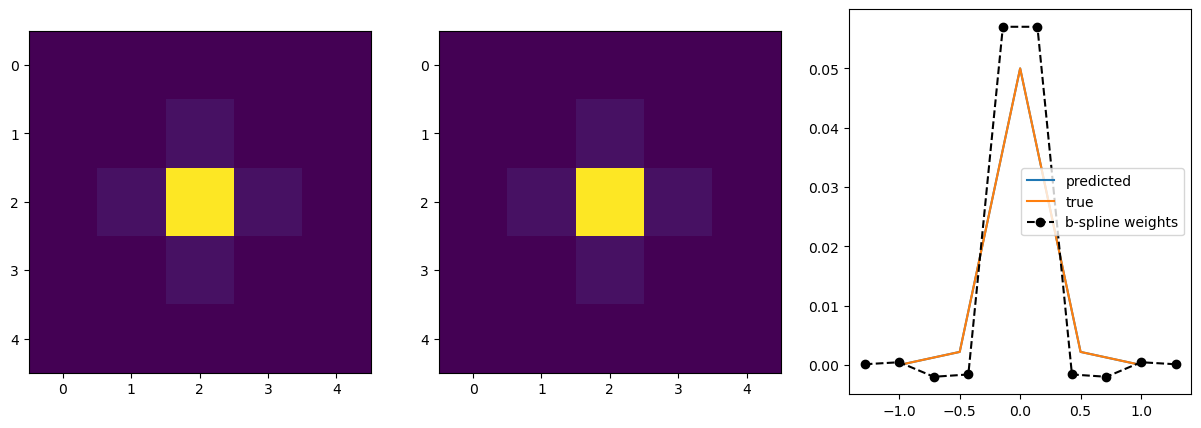

Rank:  tensor(992)
Condition number:  tensor(13002.7051)


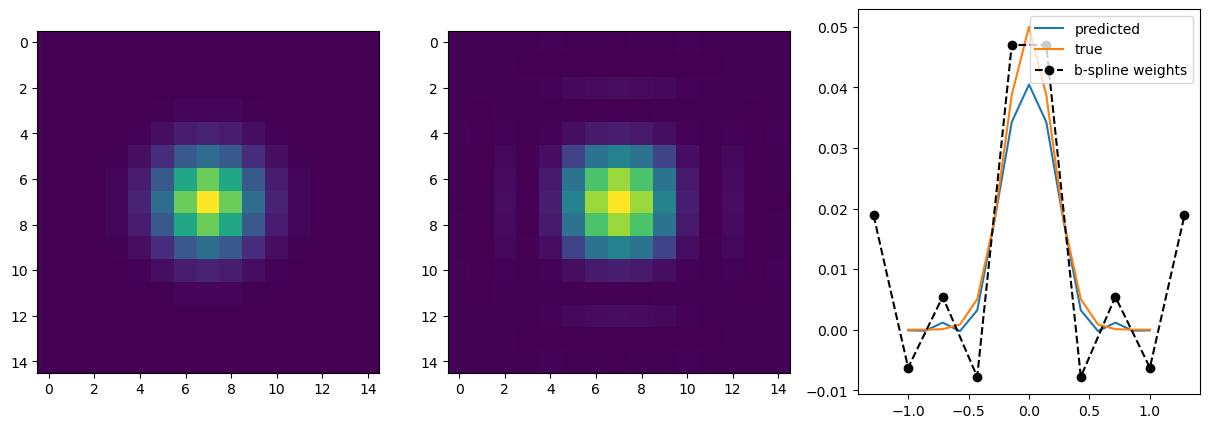

Rank:  tensor(782)
Condition number:  tensor(23212.3613)


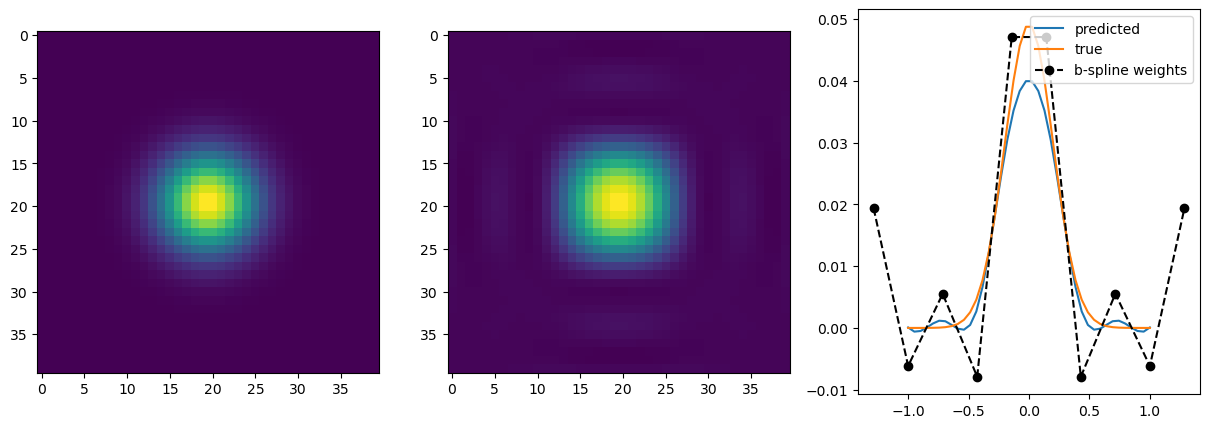

Rank:  tensor(329)
Condition number:  tensor(36392.3594)


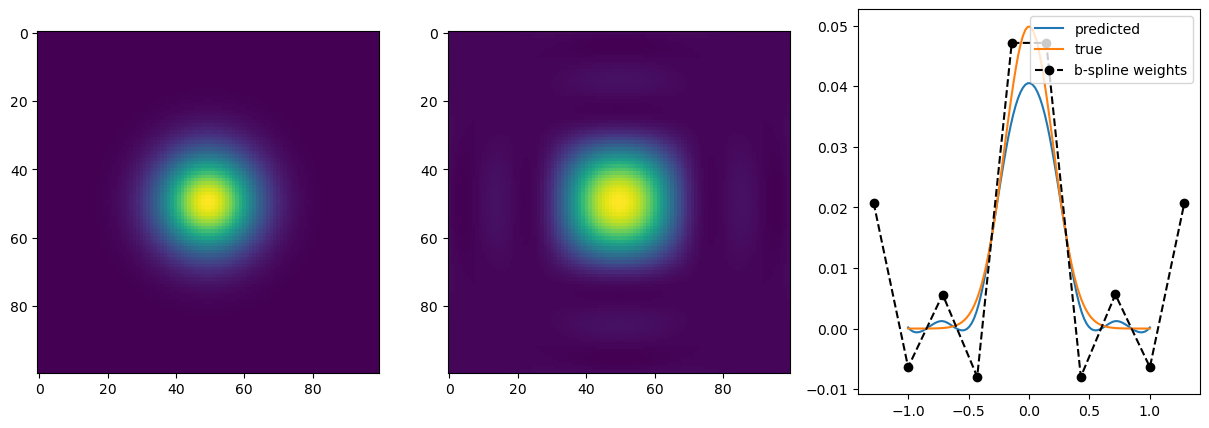

In [6]:
df = GaussianDisplacementField([0.2,0.2,0.2], [0.05,0,0], [0,0,0])

for nsamples in [5,15,40,100]:
    x = torch.linspace(-1+1e-4, 1-1e-4, nsamples)
    y = torch.linspace(-1+1e-4, 1-1e-4, nsamples)
    z = torch.linspace(-1+1e-4, 1-1e-4, nsamples)
    X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
    u = df.displacement(X, Y, Z, 0)
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].imshow(u[:,:,len(z)//2].numpy())

    weights = torch.zeros(1,10,10,10)
    bf = BSplineField(weights, False)
    _x = X.flatten()
    _y = Y.flatten()
    _z = Z.flatten()
    A = bf.get_A_matrix(_x, _y, _z)
    A = torch.Tensor(A.todense())
    print('Rank: ', torch.linalg.matrix_rank(A))
    print('Condition number: ', torch.linalg.cond(A))
    computed_weights = bf.compute_weights_from_displacement(_x, _y, _z, u.flatten())
    bf.phi_x[0,...] = computed_weights
    # plot the predicted displacement
    u_post = bf.displacement(X, Y, Z, 0)
    ax[1].imshow(u_post[:,:,len(z)//2].numpy())
    ax[2].plot(x.numpy(), u_post[:, len(y)//2, len(z)//2].numpy(), label='predicted')
    ax[2].plot(x.numpy(), u[:, len(y)//2, len(z)//2].numpy(), label='true')
    # plot grid points and weights
    nx,ny,nz = bf.grid_size
    grid_points = bf.origin[0] + bf.spacing[0] * torch.arange(nx)
    ax[2].plot(grid_points.numpy(), bf.phi_x[0,:,ny//2,nz//2], ls='--', c='k', marker='o', label='b-spline weights')
    ax[2].legend()
    plt.show()

**Potential solution would be to try to constrain the weights of the boundary nodes to 0. That would presumably reduce oscillations**

## It helps to enable support outside domain and use these points to clamp the boundary

Rank:  tensor(1000)
Condition number:  tensor(90.2252)


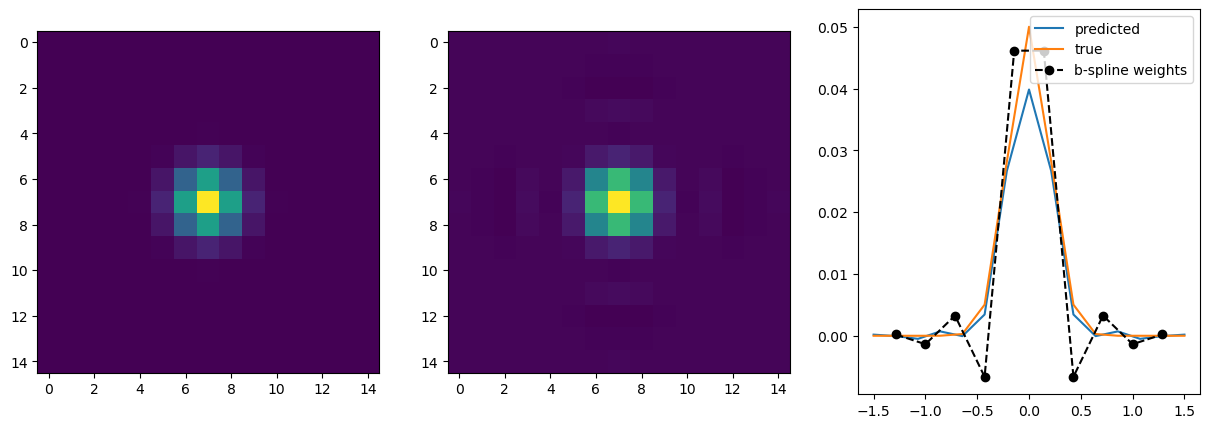

In [7]:
df = GaussianDisplacementField([0.2,0.2,0.2], [0.05,0,0], [0,0,0])

nsamples = 15
x = torch.linspace(-1.5+1e-4, 1.5-1e-4, nsamples)
y = torch.linspace(-1.5+1e-4, 1.5-1e-4, nsamples)
z = torch.linspace(-1.5+1e-4, 1.5-1e-4, nsamples)
X,Y,Z = torch.meshgrid(x,y,z, indexing='ij')
u = df.displacement(X, Y, Z, 0)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(u[:,:,len(z)//2].numpy())

nx = ny = nz = 10
weights = torch.zeros(1,nx,ny,nz)
bf = BSplineField(weights, True)
_x = X.flatten()
_y = Y.flatten()
_z = Z.flatten()
A = bf.get_A_matrix(_x, _y, _z)
A = torch.Tensor(A.todense())
print('Rank: ', torch.linalg.matrix_rank(A))
print('Condition number: ', torch.linalg.cond(A))
computed_weights = bf.compute_weights_from_displacement(_x, _y, _z, u.flatten())
bf.phi_x[0,...] = computed_weights
# plot the predicted displacement
u_post = bf.displacement(X, Y, Z, 0)
ax[1].imshow(u_post[:,:,len(z)//2].numpy())
ax[2].plot(x.numpy(), u_post[:, len(y)//2, len(z)//2].numpy(), label='predicted')
ax[2].plot(x.numpy(), u[:, len(y)//2, len(z)//2].numpy(), label='true')
# plot grid points and weights
nx,ny,nz = bf.grid_size
grid_points = bf.origin[0] + bf.spacing[0] * torch.arange(nx)
ax[2].plot(grid_points.numpy(), bf.phi_x[0,:,ny//2,nz//2], ls='--', c='k', marker='o', label='b-spline weights')
ax[2].legend()
plt.show()